# One Shot Learning with Siamese Networks

This is the jupyter notebook that accompanies

## Imports
All the imports are defined here

In [1]:
import os

In [2]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [ ]:
!rm -r signatures



rm: cannot remove 'signatures': No such file or directory


In [3]:
#!mv Abhishek AmirKhan Amitab AnilKapoor MotherTresa training_data
!wget https://cedar.buffalo.edu/NIJ/data/signatures.rar
!unrar x signatures.rar
!mkdir training_data
!mkdir testing_data
!mkdir training_data/Author1_org
!mkdir training_data/Author1_forg
!cp signatures/full_org/original_1_* training_data/Author1_org
!cp signatures/full_forg/forgeries_1_* training_data/Author1_forg
!mkdir testing_data/Author1_org
!mkdir testing_data/Author1_forg
!cp signatures/full_org/original_1_4.png testing_data/Author1_org
!cp signatures/full_forg/forgeries_1_4.png testing_data/Author1_forg
!cp signatures/full_org/original_2_4.png testing_data/Author1_org
!cp signatures/full_forg/forgeries_2_4.png testing_data/Author1_forg
!mkdir training_data/Author2_org
!mkdir training_data/Author2_forg
!cp signatures/full_org/original_2_* training_data/Author2_org
!cp signatures/full_forg/forgeries_2_* training_data/Author2_forg
#!mv signatures/full_forg signatures/full_org training_data
#!mv training_data/Author1 training_data/Author1_orig
#!cp signatures/full_org/original_1_* training_data/Author1_org
#!mkdir training_data/Author1_org
#!cp signatures/full_forg/forgeries_1_* training_data/Author1_forg
#!rm -r training_data/Author1_orig
#!cp signatures/full_org/original_1_4.png* testing_data/
#!cp signatures/full_forg/forgeries_1_4.png testing_data/
#!mkdir testing_data/Author1_org
#!mkdir testing_data/Author1_forg
#!cp signatures/full_org/original_1_4.png testing_data/Author1_org
#!cp signatures/full_forg/forgeries_1_4.png testing_data/Author1_forg
#!cp signatures/full_org/original_2_4.png testing_data/Author1_org
#!cp signatures/full_forg/forgeries_2_4.png testing_data/Author1_forg


--2023-09-10 08:23:58--  https://cedar.buffalo.edu/NIJ/data/signatures.rar
Resolving cedar.buffalo.edu (cedar.buffalo.edu)... 128.205.33.100
Connecting to cedar.buffalo.edu (cedar.buffalo.edu)|128.205.33.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 253587033 (242M) [text/plain]
Saving to: ‘signatures.rar’

signatures.rar      100%[===================>] 241.84M  65.7MB/s    in 4.3s    

2023-09-10 08:24:03 (56.5 MB/s) - ‘signatures.rar’ saved [253587033/253587033]


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from signatures.rar

Creating    signatures                                                OK
Creating    signatures/full_forg                                      OK
Extracting  signatures/full_forg/forgeries_10_1.png                        0%  OK 
Extracting  signatures/full_forg/forgeries_10_10.png                       0%  OK 
Extracting  signatures/full_forg/forgeries_10_11.png        

In [4]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

## Configuration Class
A simple class to manage configuration

In [5]:
class Config():
    training_dir = "training_data"
    testing_dir = "testing_data"
    train_batch_size = 64
    train_number_epochs = 100
    num_classes=5

## Custom Dataset Class
This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair

In [6]:
class SiameseNetworkDataset(Dataset):

    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform
        self.should_invert = should_invert

    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #print(img0_tuple)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1)
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found

                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] !=img1_tuple[1]:#code to get any 2 different pairs
                #if (img0_tuple[1]==0 and img1_tuple[1]==1) or (img0_tuple[1]==2 and img1_tuple[1]==3):
                  break

        print("imagepair",img0_tuple[1],':',img1_tuple[1])
        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))

    def __len__(self):
        return len(self.imageFolderDataset.imgs)

## Using Image Folder Dataset

In [7]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [8]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
1 indiciates dissimilar, and 0 indicates similar.

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


imagepairimagepairimagepair imagepairimagepair0imagepair imagepair     1020imagepair  :2    2  2:: 3: ::
 : : 2  021  1

0
0



imagepairimagepairimagepairimagepairimagepairimagepairimagepair imagepair   3      033101:2      ::3::::    
   imagepair:022313
 


 

03imagepairimagepairimagepair
 imagepairimagepair   imagepair : 02210  imagepair     1:3 :: ::
 1   0 :imagepair 112
  :2

0 2
imagepair
1
  imagepairimagepairimagepairimagepair:
3      imagepair02331:    imagepair 
0 :::: 3 
 2:   3imagepair2 imagepair30  0

:

 31  : 0 :
imagepair1
imagepairimagepair 2 imagepair
imagepair0
imagepair   33imagepair0    ::1 : 1   imagepair   2 :0:31:1  

   :3

 0:0imagepair
 1imagepairimagepair

 2imagepair  0imagepair02    :
3 : 2   :0: 
imagepair  :1imagepair0imagepair11 imagepair 
 
1:
  3
 0imagepair imagepair
:  imagepairimagepair1 2   1 020:
2:imagepair     2  ::::: 0imagepair   2
 0  130

3imagepair 2


imagepair1
imagepair imagepair imagepair  : 0imagepair: 3  0:  2  1 
:210 
:  : :1 0

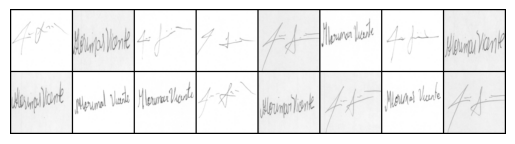


imagepairimagepair imagepair[[1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]]
1   33imagepair : ::   2 3
21 :
imagepair imagepair
 0 : 0 imagepair 3 :0
 0
0imagepair  :
 imagepair0  imagepair3 2
:3  :imagepair 0 3 0:

  0imagepair 
:3 :  20



In [9]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)
example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Neural Net Definition
We will use a standard convolutional neural network

In [10]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),

            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Contrastive Loss

In [11]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## Training Time!

In [12]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [14]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [15]:
counter = []
loss_history = []
iteration_number= 0

Streaming output truncated to the last 5000 lines.
: imagepair3
 imagepair3 : 2
 imagepair 32  : :2 3
imagepair
 3 : 2
imagepairimagepair 1  : 1
0 imagepair: 2 : 2 2

imagepairimagepair  3 :3 0
 imagepair:  3 : 03

imagepair imagepair 32 :  : 2
3imagepair 
imagepair3 :  3
3imagepair : 0  2:
 imagepair 13 
imagepair:  1
1 :imagepair  20 
: imagepair 12
 imagepair:  02 
: 3
imagepair 0 : 1
imagepair 0 : 1
imagepair 1 : 1
imagepair 1 : 1
imagepair 0 : 2
imagepair 3 : 3
imagepair 3 : 1
imagepair 1 : 0
imagepair 2 : 2
imagepair 0 : 2
imagepair 0 : 0
imagepair 3 : 3
imagepair 1 : 1
imagepair 3 : 3
imagepair 3 : 3
imagepair 2 : 0
imagepair 2 : 0
imagepair 2 : 0
imagepair 1 : 3
imagepair 0 : 0
imagepair 0 : 0
imagepair 3 : 1
imagepair 2 : 2
imagepair 0 : 1
imagepair 3 : 2
imagepair 1 : 0
Epoch number 49
 Current loss 0.04466002434492111

imagepairimagepair  23  ::  2
2
imagepairimagepair  13  ::  30

imagepairimagepair 2  2:  :0 2
imagepair
 imagepair2  3: :  32

imagepairimagepair  23  ::  3


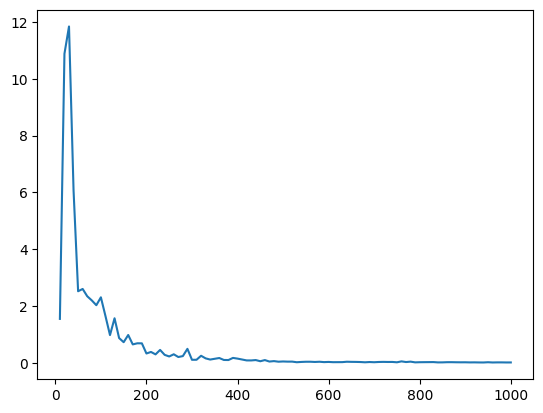

In [16]:
for epoch in range(0,100):#Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

## Some simple testing
The last 3 subjects were held out from the training, and will be used to test. The Distance between each image pair denotes the degree of similarity the model found between the two images. Less means it found more similar, while higher values indicate it found them to be dissimilar.

In [ ]:
#!mv ShahidKapoor Sushant testing_data

imagepair 0imagepair imagepair:  imagepair0  10  :
:1 
  10: 1

tensor([1.6411], device='cuda:0', grad_fn=<NormBackward1>)


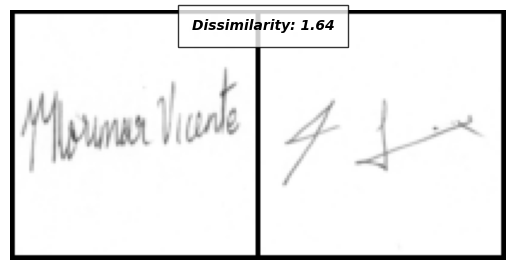

tensor([1.2875], device='cuda:0', grad_fn=<NormBackward1>)


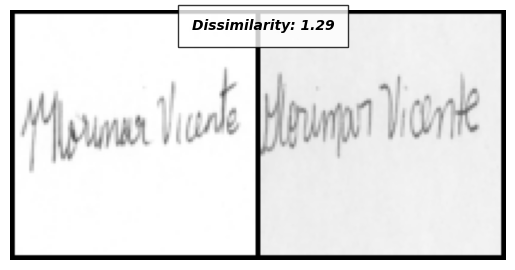

In [23]:
#folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
folder_dataset_test = dset.ImageFolder(root='testing_data')
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
for j in range(1):
  #dataiter = iter(test_dataloader)

  x0,_,_ = next(dataiter)
  #print(x0)
  for i in range(2):
    _,x1,label2 = next(dataiter)
    #print(label2)
    concatenated = torch.cat((x0,x1),0)

    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    print(euclidean_distance)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))



In [ ]:
checkpoint1 = {'state_dict': net.state_dict()}
torch.save(checkpoint1, './Siemaseteam26v4.pth')
torch.save(net,'SiemeseSignVer.pth')
